# из прошлого таска я возьму которую показала себя лучше всех, то есть lgbm

In [23]:
import pickle
import pandas as pd
# load
with open('lgbm.pkl', 'rb') as f:
    lgbm = pickle.load(f)

with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

In [24]:
lgbm.predict([[i for i in range(139)],\
              [i for i in range(139)]]) # Проверил дейстительно ли 139 столбцов должно быть

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


array([-2.91140458, -2.91140458])

In [25]:
with open('cols_from_descriptor.txt') as file:
    name_of_features = [line.strip() for line in file]

In [26]:
from rdkit import Chem
from rdkit.Chem import Descriptors

def get_descriptors(df):
    mol_list = []
    for smile in df['smiles']:
        mol = Chem.MolFromSmiles(smile)
        mol = Chem.AddHs(mol)
        mol_list.append(mol)
    df['mol'] = mol_list

    lis = []
    for mol in df['mol']:
        #display(Draw.MolToImage(mol))
        all_descriptors = Descriptors.CalcMolDescriptors(mol)
        lis.append(all_descriptors)
    descrps = pd.DataFrame(lis)
    descrps = descrps[name_of_features]
    #res_df = df[name_of_features]
    return descrps

# сгенерированные молекулы были сделаны с помощью drugGpt

In [27]:
generated_molecules = pd.read_csv('generated_mols.csv',names=  ['num','smiles'])
generated_molecules = generated_molecules.drop(['num'], axis = 1)

for i in generated_molecules['smiles']:
    if not Chem.MolFromSmiles(i):
        generated_molecules.drop(index=generated_molecules[generated_molecules['smiles'] == i].index, inplace=True)

[17:08:39] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 14


In [28]:
generated_molecules

,smiles
0,CS(=O)(=O)c1ccc(cc1)-n1cc(nc1-c1ccc(cc1)[N+]([...
1,CS(=O)(=O)c1ccc(cc1)-n1cc(nc1-c1cc(Cl)cc(Cl)c1...
2,CS(=O)(=O)c1ccc(cc1)-c1cc(Br)sc1-c1ccc(F)cc1
3,CS(=O)(=O)c1ccc(cc1)-n1cc(nc1-c1ccc(Cl)cc1)C(F...
4,NS(=O)(=O)c1ccc(cc1)-n1cc(nc1-c1ccc(Cl)c(Cl)c1...
...,...
195,CS(=O)(=O)c1ccc(cc1)-c1cnn(CC(F)(F)F)c(=O)c1-c...
196,Cc1ccc(cc1)-c1nc(cn1-c1ccc(cc1)S(C)(=O)=O)C(F)...
197,Cc1ccc(cc1)-n1c(SCc2cn(nn2)-c2ccc(cc2)C(F)(F)F...
198,COc1ccc(cc1OC)-c1nc(cn1-c1ccc(cc1)S(N)(=O)=O)C...


In [29]:

X = get_descriptors(generated_molecules)

X_scaled = scaler.transform(X)

In [30]:
predicts = lgbm.predict(X_scaled)
predicts.shape

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


(199,)

<Axes: >

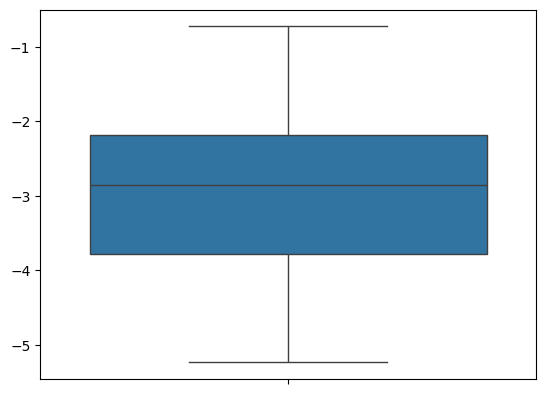

In [31]:
import seaborn as sns

sns.boxplot(predicts)

# Результаты оставляют желать лучшего))).

# Пытался залезть в другой генератор freedd++, но понимаю что с ним я буду очень долго разбираться. Пытался получить формат pdbqt для freedd++, но вылазили вечные ошибки, то там, то тут

In [32]:
predicts = pd.Series(predicts)
predicts.rename('predicted_value', inplace=True)

0     -3.428640
1     -3.502452
2     -2.084740
3     -3.631124
4     -3.778018
         ...   
194   -3.508372
195   -3.430240
196   -3.742184
197   -4.077348
198   -2.886730
Name: predicted_value, Length: 199, dtype: float64

<Axes: ylabel='predicted_value'>

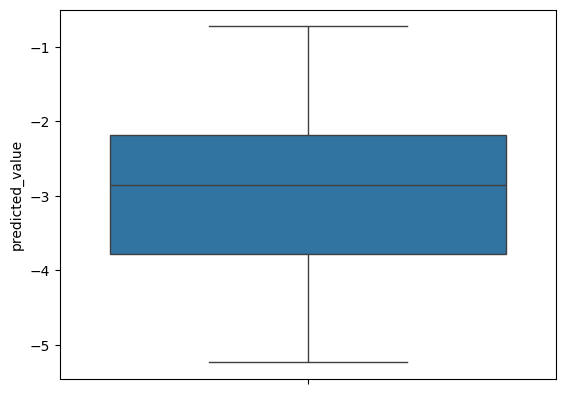

In [33]:
generated_molecules.reset_index(inplace=True, drop=True)
predicts.reset_index(inplace=True, drop=True)
generated_molecules = pd.concat([generated_molecules, predicts], axis = 1)

sns.boxplot(generated_molecules.predicted_value)

In [34]:
import rdkit
def calculate_qed(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return rdkit.Chem.QED.qed(mol)

generated_molecules['qed'] = generated_molecules['smiles'].apply(calculate_qed)

In [35]:
import rdkit.Contrib.SA_Score.sascorer as sascorer # Обратите внимание на путь


def calculate_sa_score(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return sascorer.calculateScore(mol)

generated_molecules['sa_score'] = generated_molecules['smiles'].apply(calculate_sa_score)

<Axes: ylabel='sa_score'>

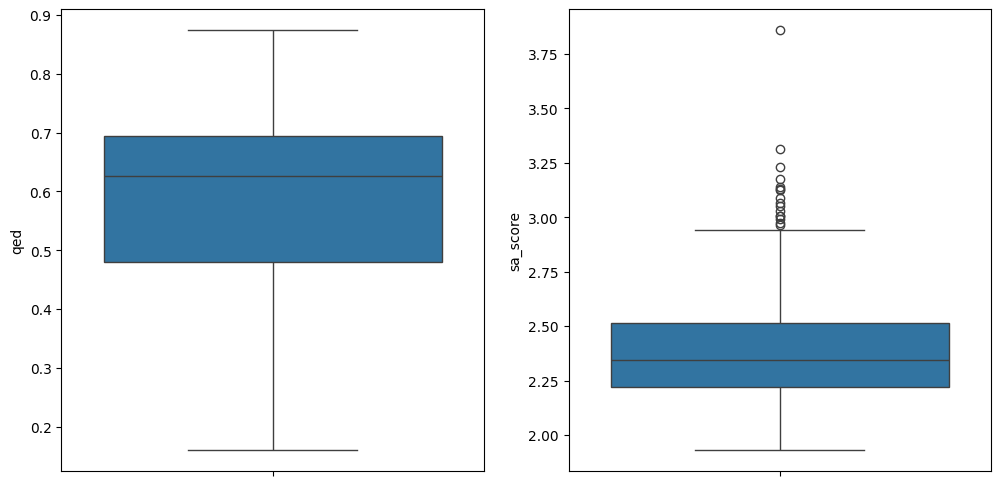

In [36]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.boxplot(generated_molecules['qed'], ax = axes[0])
sns.boxplot(generated_molecules['sa_score'], ax = axes[1])

In [37]:
from rdkit import Chem
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams

def count_brenk_matches(smiles):

    mol = Chem.MolFromSmiles(smiles)

    if not hasattr(count_brenk_matches, 'catalog'):
        params = FilterCatalogParams()
        params.AddCatalog(FilterCatalogParams.FilterCatalogs.BRENK)
        count_brenk_matches.catalog = FilterCatalog(params)

    matches = count_brenk_matches.catalog.GetMatches(mol)

    return len(matches)


array([[<Axes: title={'center': 'brenk_matches'}>]], dtype=object)

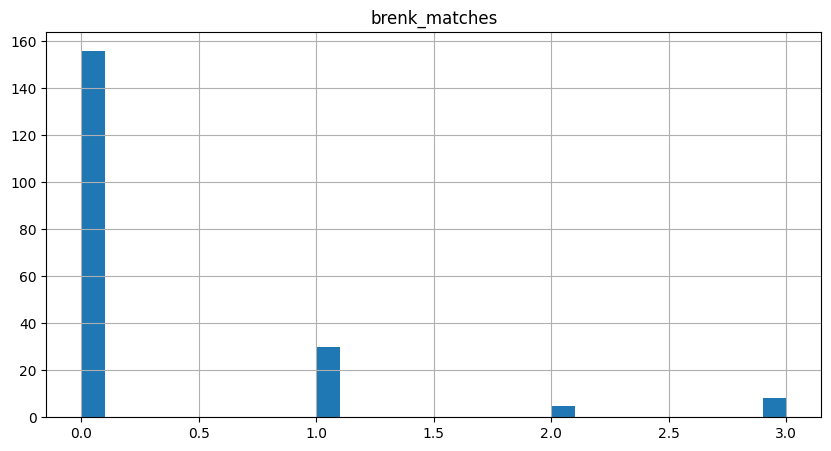

In [38]:
generated_molecules['brenk_matches'] = generated_molecules['smiles'].apply(count_brenk_matches)

generated_molecules.hist(column='brenk_matches', bins=30, figsize=(10, 5))

In [39]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.rdMolDescriptors import CalcExactMolWt, CalcNumLipinskiHBD, CalcNumLipinskiHBA

def count_lipinski_violations_simple(smiles: str) -> int:

    mol = Chem.MolFromSmiles(smiles)

    violations_count = 0

    # 1. Молекулярная масса (MW)
    mw = CalcExactMolWt(mol)
    if mw >= 500:
        violations_count += 1

    # 2. Число доноров водородных связей (HBD)
    hbd = CalcNumLipinskiHBD(mol)
    if hbd > 5:
        violations_count += 1

    # 3. Число акцепторов водородных связей (HBA)
    hba = CalcNumLipinskiHBA(mol)
    if hba > 10:
        violations_count += 1

    # 4. Коэффициент распределения октанол-вода (LogP)
    logp = Descriptors.MolLogP(mol)
    if logp > 5:
        violations_count += 1

    return violations_count


In [40]:
generated_molecules['lipinski_violations'] = generated_molecules['smiles'].apply(count_lipinski_violations_simple)

<Axes: xlabel='lipinski_violations'>

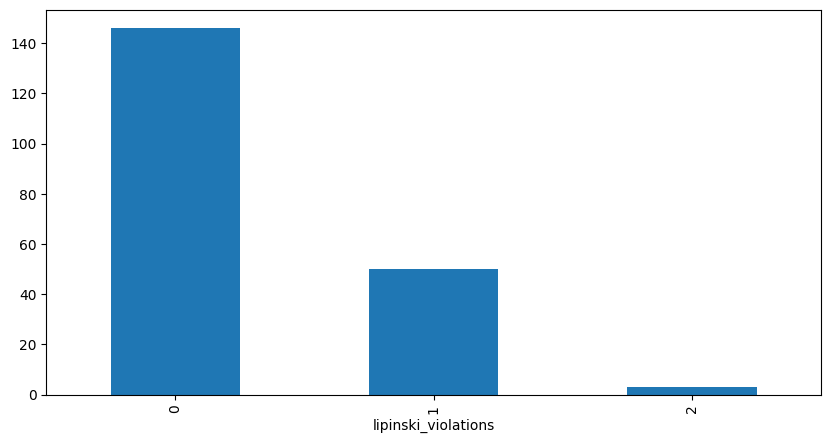

In [41]:
generated_molecules.lipinski_violations.value_counts().plot(kind='bar', figsize=(10, 5))

Итоговый список молекул должен соответствовать:

pValue > 6.0

QED > 0.7 (в крайнем случае ≥ 0.5)

2 < SA Score < 6

Отсутствие токсофоров (по SMARTS или BRENK)

Не более одного нарушения правил Липинского

In [42]:

cond1 = generated_molecules.qed > 0.7
cond2 = (generated_molecules.sa_score  > 2) & (generated_molecules.sa_score < 6)
cond3 = generated_molecules.brenk_matches == 0
cond4 = generated_molecules.lipinski_violations <= 1

res_mask = cond1 & cond2 & cond3 & cond4


 # Подходящие молекулы, не учитывая первое условие  pIC50 > 6.0

In [43]:
generated_molecules[res_mask]

,smiles,mol,predicted_value,qed,sa_score,brenk_matches,lipinski_violations
5,Cc1cc(=O)c(-c2ccc(cc2)S(C)(=O)=O)c(o1)-c1ccc(F...,<rdkit.Chem.rdchem.Mol object at 0x000001C73F4...,-2.493865,0.713820,2.200563,0,0
9,CS(=O)(=O)c1ccc(cc1)-c1[nH]c(Br)cc1-c1ccc(F)cc1,<rdkit.Chem.rdchem.Mol object at 0x000001C73F4...,-2.084740,0.703020,2.261530,0,0
11,NS(=O)(=O)c1ccc(cc1)-n1nc(cc1-c1cccc(F)c1)C(F)...,<rdkit.Chem.rdchem.Mol object at 0x000001C73F4...,-3.750893,0.702683,2.219366,0,0
18,Cc1nc(c(s1)-c1ccc(cc1)S(N)(=O)=O)-c1ccc(F)cc1,<rdkit.Chem.rdchem.Mol object at 0x000001C73F4...,-2.236430,0.786218,2.050337,0,0
20,Cc1c(CC(O)=O)cc(-c2ccc(cc2)S(C)(=O)=O)n1-c1ccc...,<rdkit.Chem.rdchem.Mol object at 0x000001C73F4...,-3.855871,0.725424,2.205058,0,0
25,Cc1ccc(cc1)-c1cc(nn1-c1ccc(cc1)S(N)(=O)=O)C(F)...,<rdkit.Chem.rdchem.Mol object at 0x000001C73F4...,-2.712971,0.754105,2.144357,0,0
30,CS(=O)(=O)c1ccc(cc1)-c1[nH]c(Cl)cc1-c1ccc(F)cc1,<rdkit.Chem.rdchem.Mol object at 0x000001C73F4...,-1.660028,0.754011,2.233123,0,0
45,COc1ccc(cc1)-c1cc(nn1-c1ccc(cc1)S(N)(=O)=O)C(F...,<rdkit.Chem.rdchem.Mol object at 0x000001C73F4...,-4.084468,0.732386,2.146260,0,0
48,Cc1c(CC(O)=O)cc(-c2ccc(cc2)S(C)(=O)=O)n1-c1ccc...,<rdkit.Chem.rdchem.Mol object at 0x000001C73F4...,-3.855871,0.725424,2.262035,0,0
50,CC(C)c1cc(cc2c1OCC2(C)C)C(=O)c1cccc(c1)S(C)(=O)=O,<rdkit.Chem.rdchem.Mol object at 0x000001C73F4...,-1.255134,0.757818,2.627385,0,0
